# Longer-term weather forecasting

## Background

Extreme weather events are sweeping the globe and range from heat waves, wildfires and drought to hurricanes, extreme rainfall and flooding. These weather events have multiple impacts on agriculture, energy, transportation, as well as low resource communities and disaster planning in countries across the globe.

Accurate long-term forecasts of temperature and precipitation are crucial to help people prepare and adapt to these extreme weather events. Currently, purely physics-based models dominate short-term weather forecasting. But these models have a limited forecast horizon. The availability of meteorological data offers an opportunity for data scientists to improve sub-seasonal forecasts by blending physics-based forecasts with machine learning. Sub-seasonal forecasts for weather and climate conditions (lead-times ranging from 15 to more than 45 days) would help communities and industries adapt to the challenges brought on by climate change.

## Project overview

This project focuses on a prediction task involving forecasting sub-seasonal temperatures (temperatures over a two-week period) within the United States. The dataset used consists of weather and climate information for a number of US locations, for a number of start dates for the two-week observation, as well as the forecasted temperature and precipitation from a number of weather forecast models. Each row in the data corresponds to a single location and a single start date for the two-week period. The task is to predict the arithmetic mean of the maximum and minimum temperature over the next 14 days, for each location and start date.

## Data Understanding

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LassoCV, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

%matplotlib inline

There are two datasets provided:
- train_data.csv: the training dataset, where contest-tmp2m-14d__tmp2m, the arithmetic mean of the max and min observed temperature over the next 14 days for each location and start date, is provided
- test_data.csv: the test dataset, where the true value of contest-tmp2m-14d__tmp2m for each row is not provided.

In [3]:
#load the train dataset
train_df = pd.read_csv('Data/train_data.csv')
train_df.head()

,index,lat,lon,startdate,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,...,wind-vwnd-925-2010-11,wind-vwnd-925-2010-12,wind-vwnd-925-2010-13,wind-vwnd-925-2010-14,wind-vwnd-925-2010-15,wind-vwnd-925-2010-16,wind-vwnd-925-2010-17,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20
0,0,0.0,0.833333,9/1/14,237.00,29.02,31.64,29.57,30.73,29.71,...,-27.68,-37.21,8.32,9.56,-2.03,48.13,28.09,-13.50,11.90,4.58
1,1,0.0,0.833333,9/2/14,228.90,29.02,31.64,29.57,30.73,29.71,...,-21.13,-36.57,8.77,21.17,4.44,48.60,27.41,-23.77,15.44,3.42
2,2,0.0,0.833333,9/3/14,220.69,29.02,31.64,29.57,30.73,29.71,...,-10.72,-34.16,6.99,32.16,5.01,48.53,19.21,-33.16,15.11,4.82
3,3,0.0,0.833333,9/4/14,225.28,29.02,31.64,29.57,30.73,29.71,...,0.33,-31.04,6.17,39.66,-1.41,50.59,8.29,-37.22,18.24,9.74
4,4,0.0,0.833333,9/5/14,237.24,29.02,31.64,29.57,30.73,29.71,...,9.83,-31.80,7.47,38.62,-5.21,54.73,-2.58,-42.30,21.91,10.95


In [4]:
#load the test dataset
test_df = pd.read_csv('Data/test_data.csv')
test_df.head(2)

,index,lat,lon,startdate,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,...,wind-vwnd-925-2010-11,wind-vwnd-925-2010-12,wind-vwnd-925-2010-13,wind-vwnd-925-2010-14,wind-vwnd-925-2010-15,wind-vwnd-925-2010-16,wind-vwnd-925-2010-17,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20
0,375734,0.0,0.833333,11/1/22,339.88,30.88,30.92,29.17,31.02,29.47,...,-19.28,-39.77,-29.25,40.88,-8.31,14.91,-24.62,31.05,-23.69,6.27
1,375735,0.0,0.833333,11/2/22,334.63,30.88,30.92,29.17,31.02,29.47,...,-19.58,-43.14,-28.62,45.37,-5.42,16.97,-23.94,28.84,-20.61,14.16


In [5]:
# number of rows and columns
print(f'Shape of train data: {train_df.shape}')
print(f'Shape of test data: {test_df.shape}')

Shape of train data: (375734, 246)
Shape of test data: (31354, 245)


In [6]:
# summary of test dataset
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31354 entries, 0 to 31353
Columns: 245 entries, index to wind-vwnd-925-2010-20
dtypes: float64(241), int64(2), object(2)
memory usage: 58.6+ MB


In [7]:
# summary of train dataset
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375734 entries, 0 to 375733
Columns: 246 entries, index to wind-vwnd-925-2010-20
dtypes: float64(240), int64(4), object(2)
memory usage: 705.2+ MB


In [8]:
#column names of train_df
train_df.columns

Index(['index', 'lat', 'lon', 'startdate',
       'contest-pevpr-sfc-gauss-14d__pevpr', 'nmme0-tmp2m-34w__cancm30',
       'nmme0-tmp2m-34w__cancm40', 'nmme0-tmp2m-34w__ccsm30',
       'nmme0-tmp2m-34w__ccsm40', 'nmme0-tmp2m-34w__cfsv20',
       ...
       'wind-vwnd-925-2010-11', 'wind-vwnd-925-2010-12',
       'wind-vwnd-925-2010-13', 'wind-vwnd-925-2010-14',
       'wind-vwnd-925-2010-15', 'wind-vwnd-925-2010-16',
       'wind-vwnd-925-2010-17', 'wind-vwnd-925-2010-18',
       'wind-vwnd-925-2010-19', 'wind-vwnd-925-2010-20'],
      dtype='object', length=246)

In [9]:
# columns of dtype object
train_df.select_dtypes(include='object').head(2)

,startdate,climateregions__climateregion
0,9/1/14,BSh
1,9/2/14,BSh


In [10]:
# unique values of columns with dtype int64
for col in train_df.select_dtypes(include='int64').columns:
    print(train_df[col].value_counts())
    print('***************************')

0         1
250496    1
250494    1
250493    1
250492    1
         ..
125243    1
125242    1
125241    1
125240    1
375733    1
Name: index, Length: 375734, dtype: int64
***************************
4    59110
3    50372
7    49344
1    47802
6    46260
2    43690
8    41120
5    38036
Name: mjo1d__phase, dtype: int64
***************************
67    94062
66    78128
48    30326
37    22102
44    15934
47    15934
53    15934
63    15934
64    15934
49    15420
51    15420
61    15420
60    15420
56     9766
Name: mei__meirank, dtype: int64
***************************
4    291438
3     84296
Name: mei__nip, dtype: int64
***************************


The target variable is the the arithmetic mean of the max and min observed temperature over the next 14 days for each location, and start date: 'contest-tmp2m-14d__tmp2m'.

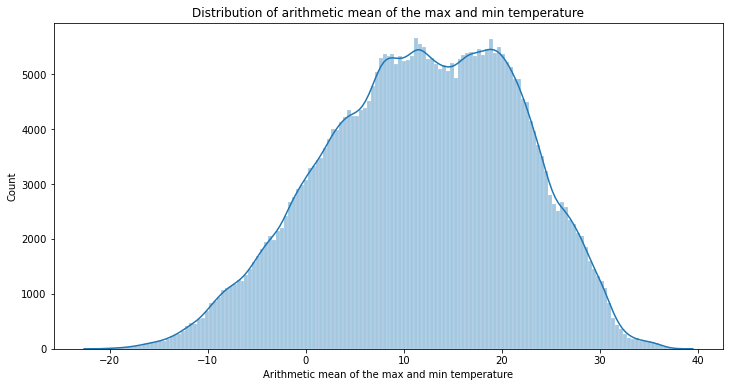

In [11]:
# Distribution of target variable - 'contest-tmp2m-14d__tmp2m'
fig, ax = plt.subplots(figsize=(12,6))
sns.histplot(train_df['contest-tmp2m-14d__tmp2m'], kde=True, kde_kws=dict(cut=3),
             alpha=.4, edgecolor=(1, 1, 1, .4), ax=ax)
ax.set_title('Distribution of arithmetic mean of the max and min temperature')
ax.set_xlabel('Arithmetic mean of the max and min temperature');

The arithmetic mean temperature is between -20 and 40. The temperature is more normally distributed. It is slightly skewed to the left.

## Data Preparation

### Duplicates

In [12]:
# check for duplicates
train_df.duplicated().value_counts()

False    375734
dtype: int64

No duplicates in the dataset.

### Missing values

In [13]:
# columns with missing values
#or use train_df[train_df.columns[train_df.isnull().any()]].isnull().sum()
indexes = train_df.isna().sum().index
values = train_df.isna().sum().values
for index, value in zip(indexes, values):
    if value:
        print(f'{index} : {value}')

nmme0-tmp2m-34w__ccsm30 : 15934
nmme-tmp2m-56w__ccsm3 : 10280
nmme-prate-34w__ccsm3 : 8738
nmme0-prate-56w__ccsm30 : 15934
nmme0-prate-34w__ccsm30 : 15934
nmme-prate-56w__ccsm3 : 10280
nmme-tmp2m-34w__ccsm3 : 8738
ccsm30 : 15934


The missing values can be replaced with the mean. The records with missing values can't be dropped because it constitutes around half of the whole dataset.

In [14]:
cols = ['nmme0-tmp2m-34w__ccsm30', 'nmme-tmp2m-56w__ccsm3', 'nmme-prate-34w__ccsm3', 'nmme0-prate-56w__ccsm30', 'nmme0-prate-34w__ccsm30', 'nmme-prate-56w__ccsm3', 'nmme-tmp2m-34w__ccsm3', 'ccsm30']
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean = imp_mean.fit(train_df[cols])
train_df[cols] = imp_mean.transform(train_df[cols])

In [15]:
#re-check for missing values
train_df[train_df.columns[train_df.isnull().any()]].isnull().sum()

Series([], dtype: float64)

In [16]:
# missing values for test dataset
test_df[test_df.columns[test_df.isnull().any()]].isnull().sum()

Series([], dtype: float64)

### Separate predictor and target variables

In [17]:
#drop irrelevant column
train_df.drop(columns=['index'], inplace=True)
X_test = test_df.drop(columns=['index'])

In [18]:
#Obtain the target and features from the training set
y_train = train_df['contest-tmp2m-14d__tmp2m']
X_train = train_df.drop(columns='contest-tmp2m-14d__tmp2m')

### Feature engineering

Convert startdate from dtype object to datetime, and add new features day of the year, month, and season

In [19]:
# function for adding day_of_year and month
def build_date_features(df, ref_set, date_key='startdate'):
  df[date_key] = pd.to_datetime(ref_set[date_key])
  df['day_of_year'] = df[date_key].dt.day_of_year
  df['month'] = df[date_key].dt.month 

build_date_features(X_train, train_df)
build_date_features(X_test, test_df)

In [21]:
# drop startdate column
X_train = X_train.drop('startdate', axis=1) 
X_test = X_test.drop('startdate', axis=1)
X_train.head(2)

,lat,lon,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,nmme0-tmp2m-34w__gfdlflora0,nmme0-tmp2m-34w__gfdlflorb0,...,wind-vwnd-925-2010-13,wind-vwnd-925-2010-14,wind-vwnd-925-2010-15,wind-vwnd-925-2010-16,wind-vwnd-925-2010-17,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20,day_of_year,month
0,0.0,0.833333,237.0,29.02,31.64,29.57,30.73,29.71,31.52,31.68,...,8.32,9.56,-2.03,48.13,28.09,-13.50,11.90,4.58,244,9
1,0.0,0.833333,228.9,29.02,31.64,29.57,30.73,29.71,31.52,31.68,...,8.77,21.17,4.44,48.60,27.41,-23.77,15.44,3.42,245,9


In [22]:
def add_season(df):
    """Winter months(0): December, January, February.
    Spring months(1): March, April, May.
    Summer months(2): June, July, August.
    Fall months(3): September, October, November."""

    month_to_season = {
      1: 0,
      2: 0,
      3: 1,
      4: 1,
      5: 1,
      6: 2,
      7: 2,
      8: 2, 
      9: 3, 
      10: 3,
      11: 3,
      12: 0
  }
    df['season'] = df['month'].apply(lambda x: month_to_season[x])

add_season(X_train)
add_season(X_test)

We also take advantage of cyclical feature encoding- sine and cosine encoding this variable to take advantage of the cyclical nature of a year's time period. 

In [24]:
## https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

In [25]:
def encode_cyclical(df):
  # encode the day with a period of 365
  df['day_of_year_sin'] = sin_transformer(365).fit_transform(df['day_of_year'])
  df['day_of_year_cos'] = cos_transformer(365).fit_transform(df['day_of_year'])

  # encode the month with a period of 12
  df['month_sin'] = sin_transformer(12).fit_transform(df['month'])
  df['month_cos'] = cos_transformer(12).fit_transform(df['month'])

  # encode the season with a period of 4
  df['season_sin'] = sin_transformer(4).fit_transform(df['season'])
  df['season_cos'] = cos_transformer(4).fit_transform(df['season'])

encode_cyclical(X_train)
encode_cyclical(X_test)

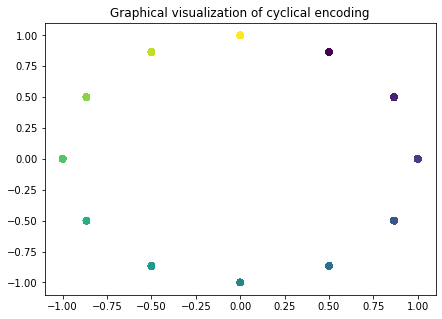

In [37]:
all_data = pd.concat([X_train, X_test])
fig, ax = plt.subplots(figsize=(7, 5))
plt.title("Graphical visualization of cyclical encoding")
ax.scatter(all_data["month_sin"], all_data["month_cos"], c=all_data["month"]);

In [34]:
# 9 date features added; startdate and index dropped
X_train.shape

(375734, 252)

### Multicollinearity of features

In [48]:
# pairs with collinearity > 0.75
df = X_train.corr().abs().stack().reset_index().sort_values(0, ascending=False)
df['pairs'] = list(zip(df.level_0, df.level_1))
df.set_index(['pairs'], inplace = True)
df.drop(columns=['level_1', 'level_0'], inplace = True)
df.columns = ['cc']
df.drop_duplicates(inplace=True)
df[(df.cc>.80) & (df.cc<1)]

,cc
pairs,
"(gfdlflora0, gfdlflorb0)",0.998904
"(nmme0-tmp2m-34w__gfdlflora0, nmme0-tmp2m-34w__gfdlflorb0)",0.998903
"(nmme-tmp2m-56w__nmmemean, nmme-tmp2m-34w__nmmemean)",0.998309
"(nmme-tmp2m-34w__cfsv2, nmme-tmp2m-56w__cfsv2)",0.998165
"(nmme-tmp2m-56w__gfdlflorb, nmme-tmp2m-34w__gfdlflorb)",0.997922
...,...
"(nmme-tmp2m-56w__gfdlflora, contest-pevpr-sfc-gauss-14d__pevpr)",0.800542
"(nmme0-prate-34w__nasa0, nmme0-prate-34w__cfsv20)",0.800451
"(contest-pevpr-sfc-gauss-14d__pevpr, nmme-tmp2m-34w__gfdlflora)",0.800419


In [26]:
## Identify correlated features to drop that fall above a correlation threshold 
## https://goodboychan.github.io/python/datacamp/machine_learning/2020/07/08/02-Feature-selection-I-selecting-for-feature-information.html 

def identify_correlated(df, threshold):
    corr_matrix = df.corr().abs()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    reduced_corr_matrix = corr_matrix.mask(mask)
    features_to_drop = [c for c in reduced_corr_matrix.columns if any(reduced_corr_matrix[c] > threshold)]
    return features_to_drop

In [27]:
## Get the column names to drop 
to_drop = identify_correlated(X_train, threshold=0.80)
len(to_drop)

103

In [28]:
# drop columns in train data to handle multicollinearity
X_train_reduced = pd.DataFrame(X_train.drop(to_drop, axis=1))
print(X_train_reduced.shape)

(375734, 149)


In [35]:
# drop columns in test data to handle multicollinearity
X_test_reduced = pd.DataFrame(X_test.drop(to_drop, axis=1))
print(X_test_reduced.shape)

(31354, 149)


103 features have been dropped in both X_train and X_test, to handle multicollinearity

In [36]:
X_train_reduced.to_csv('Data/X_train_cleaned.csv')
X_test_reduced.to_csv('Data/X_test_cleaned.csv')

In [21]:
# LOG TRANSFORM NOT DONE - COZ OF 0 AND NEGATIVE VALUES
# SCALING DONE IN PIPELINE
# While normalized data is not a requirement for most machine learning models, 
# differences in scaling can cause problems.

In [4]:
# LOAD THE DATA
train_df = pd.read_csv('Data/train_data.csv')

#Obtain the target and features
y_train = train_df['contest-tmp2m-14d__tmp2m']
X_train_reduced = pd.read_csv('Data/X_train_cleaned.csv')
X_test_reduced = pd.read_csv('Data/X_test_cleaned.csv')

## Modeling

### 1. Baseline model - Linear Regression

In [27]:
# model using basic linear regression
baseline_model = LinearRegression()
baseline_model.fit(X_train_reduced, y_train)

LinearRegression()

In [28]:
#cross validation
cross_val = cross_validate(baseline_model, X_train_reduced, y_train, cv=8, scoring='neg_root_mean_squared_error', return_train_score=True)

# Negative signs in front to convert back to RMSE from -RMSE
train_avg = -cross_val["train_score"].mean()
test_avg = -cross_val["test_score"].mean()
print(f'Cross validation RMSE train error: {train_avg}')
print(f'Cross validation RMSE test error: {test_avg}')

Cross validation RMSE train error: 1.2685389643992555
Cross validation RMSE test error: 1.5059980515315925


In [48]:
solutions1 = pd.DataFrame()
solutions1['contest-tmp2m-14d__tmp2m'] = baseline_model.predict(X_test_reduced)
solutions1['index'] = test_df['index']
solutions1.head(3)

,contest-tmp2m-14d__tmp2m,index
0,28.204863,375734
1,28.038584,375735
2,27.863478,375736


In [49]:
solutions1.to_csv('Solutions/solutions1.csv', index = False)

RMSE is 5.291.

### 2. Lasso Regression

In [65]:
# lasso regression
lasso = LassoCV(max_iter=100000, cv=15)
lasso.fit(X_train_reduced, y_train)

print('\n----------------\n')
print('The optimal alpha for the lasso regression is: ', lasso.alpha_)


----------------

The optimal alpha for the lasso regression is:  0.009420555987980219


In [52]:
solutions2 = pd.DataFrame()
solutions2['contest-tmp2m-14d__tmp2m'] = lasso.predict(X_test_reduced)
solutions2['index'] = test_df['index']
solutions2.to_csv('Solutions/solutions2.csv', index = False)
solutions2.head(3)

,contest-tmp2m-14d__tmp2m,index
0,27.187991,375734
1,27.170391,375735
2,27.255788,375736


RMSE is 1.714. Better than the baseline model

### 3. Random forest

In [8]:
# column transformer for one hot encoding
ohe_transformer = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(handle_unknown='ignore'), ['climateregions__climateregion'])
    ], remainder='passthrough')

In [9]:
# pipeline with RandomForestRegressor estimator
pipe_rf = Pipeline(steps=[
    ('ohe', ohe_transformer), 
    ('scaler', StandardScaler()), 
    ('rf', RandomForestRegressor(random_state=42))
    ])
pipe_rf.fit(X_train_reduced, y_train)

Pipeline(steps=[('ohe',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['climateregions__climateregion'])])),
                ('scaler', StandardScaler()),
                ('rf', RandomForestRegressor(random_state=42))])

In [40]:
#cross validation
cross_val = cross_validate(pipe_rf, X_train_reduced, y_train, cv=8, scoring='neg_root_mean_squared_error', return_train_score=True)

# Negative signs in front to convert back to RMSE from -RMSE
train_avg = -cross_val["train_score"].mean()
test_avg = -cross_val["test_score"].mean()
print(f'Cross validation RMSE train error: {train_avg}')
print(f'Cross validation RMSE test error: {test_avg}')

In [39]:
# Save solution - index starts at 375734
solutions_rf = pd.DataFrame()
solutions_rf['contest-tmp2m-14d__tmp2m'] = pipe_rf.predict(X_test_reduced)
solutions_rf['index'] = test_df['index']
solutions_rf.to_csv('Solutions/solutions_rf.csv', index = False)
solutions_rf.head(3)

,contest-tmp2m-14d__tmp2m,index
0,29.582035,375734
1,29.570400,375735
2,29.629888,375736


RMSE score is 1.722. 

### Hyperparameter Tuning of the Random Forest Regressor

class sklearn.ensemble.RandomForestRegressor(n_estimators=100, *, criterion='squared_error', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=1.0, max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, ccp_alpha=0.0, max_samples=None)

In [14]:
# function for hyperparameter tuning using GridSearchCV
def rf_tuning(pipeline, n_estimators,  max_depth, min_samples_split, min_samples_leaf, max_features):
    params_rf = {'rf__n_estimators': n_estimators,
             'rf__max_depth': max_depth,
             'rf__min_samples_split': min_samples_split,
             'rf__min_samples_leaf': min_samples_leaf,
             'rf__max_features': max_features
             }

    gridsearch_rf = GridSearchCV(pipeline, params_rf, cv=4, scoring='neg_root_mean_squared_error')
    gridsearch_rf.fit(X_train_reduced, y_train)

    # parameters that gave the best result
    print(f'Optimal parameters: {gridsearch_rf.best_params_}')

    # Mean cross-validated score of the best_estimator
    print(f'Validation negative RMSE: {gridsearch_rf.best_score_}')


In [16]:
rf_tuning(pipe_rf, [200], [None, 20], [3, 5], [2, 4], ['sqrt', 'log2', 100])